## Задание: 

Нужно проанализировать данные А/B-теста, который проходил с 2024-03-29 по 2024-04-04 включительно. Для эксперимента были задействованы группы 1 и 2, во 2-ой был использован один из новых алгоритмов рекомендации постов, а 1-ая использовалась в качестве контроля. 

**Основная гипотеза**: новый алгоритм во 2-й группе приведет к увеличению CTR. 

1. Сравнить CTR в двух группах, используя:
   - t-тест
   - Пуассоновский бутстреп
   - Тест Манна-Уитни
   - t-тест на сглаженном ctr (α=5) 
   - t-тест и тест Манна-Уитни поверх бакетного преобразования
2. Посмотреть на распределения глазами, ответить на вопрос: почему тесты сработали именно так? Описать потенциальную ситуацию, когда такое изменение могло произойти (на подумать).
3. Написать рекомендацию, можно ли раскатывать новый алгоритм на всех новых пользователей или всё-таки не стоит, обосновать и аргументировать вывод.

In [1]:
import pandahouse 
import pandas as pd
import random 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connection = { #здесь были параметры подключения
    'host': "...",
    'password': "...",
    'user': '...',
    'database': "..."
}

In [3]:
q = """
    select exp_group,
           user_id, 
           sum(action='view') as views, 
           sum(action='like') as likes, 
           sum(action='like')/sum(action='view') as ctr
    from {db}.feed_actions
    where date(time) between date('2024-03-29') and date('2024-04-04')
          and exp_group in (1, 2)
    group by user_id, exp_group
"""
df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


Распределение CTR в контрольной и тестовой группах:

In [6]:
sns.set(rc={'figure.figsize':(20, 10)})

<Axes: xlabel='ctr', ylabel='Count'>

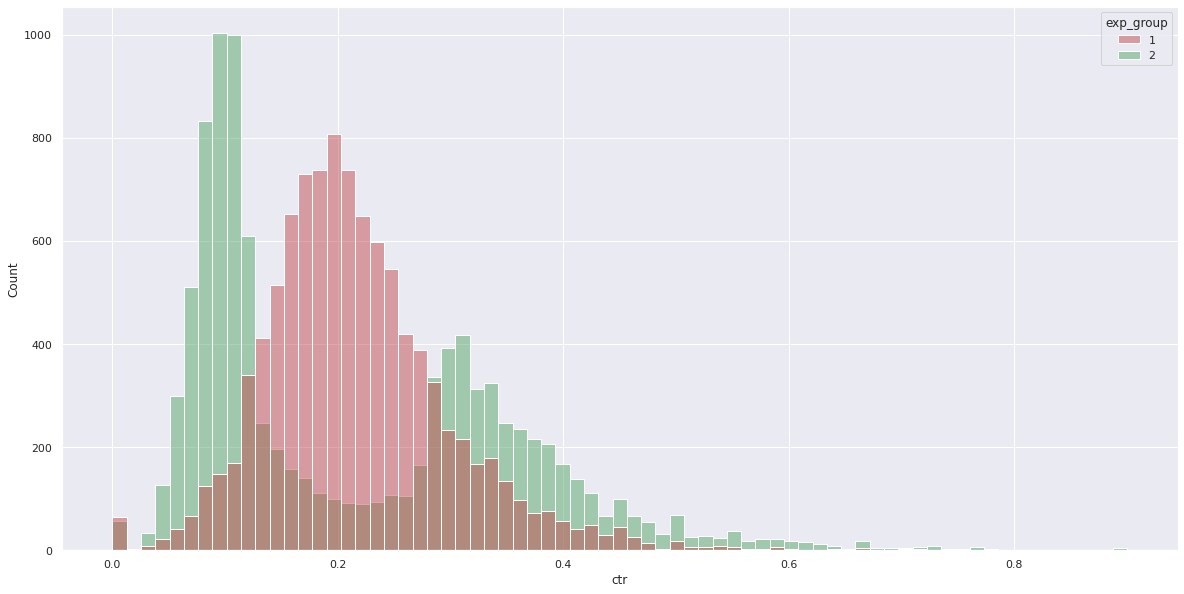

In [7]:
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'g'], alpha=0.5, kde=False)

**t-test**

In [8]:
p_value_ttest = stats.ttest_ind(df[df.exp_group==1].ctr, df[df.exp_group==2].ctr, equal_var=False)[1]

In [9]:
p_value_ttest

0.685373331140751

**Пуассоновский бутстреп**

In [10]:
likes_1 = df[df.exp_group==1].likes.to_numpy()
likes_2 = df[df.exp_group==2].likes.to_numpy()

In [11]:
views_1 = df[df.exp_group==1].views.to_numpy()
views_2 = df[df.exp_group==2].views.to_numpy()

In [12]:
subgroup_1 = stats.poisson(1).rvs((2000, len(likes_1)))
subgroup_2 = stats.poisson(1).rvs((2000, len(likes_2)))

In [13]:
global_ctr_1 = (subgroup_1 * likes_1).sum(axis=1)/(subgroup_1 * views_1).sum(axis=1)
global_ctr_2 = (subgroup_2 * likes_2).sum(axis=1)/(subgroup_2 * views_2).sum(axis=1)

Распределение группового CTR:

<Axes: ylabel='Count'>

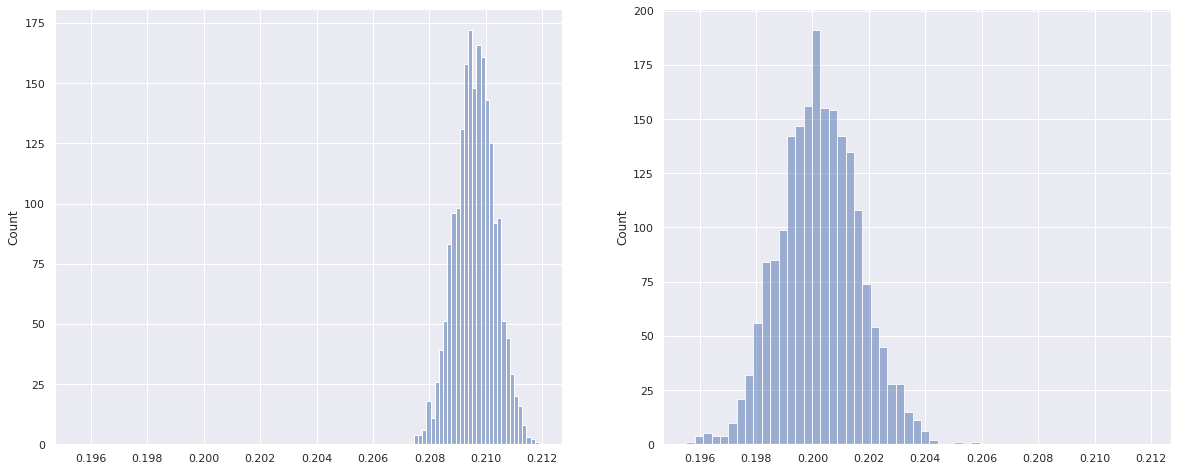

In [14]:
ctrs, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
sns.histplot(ax=axes[0], data=global_ctr_1, alpha=0.5, kde=False) #ctr контрольной группы
sns.histplot(ax=axes[1], data=global_ctr_2, alpha=0.5, kde=False) #ctr тестовой группы

Распределение разницы между групповыми CTR в контрольной и тестовой группах:

<Axes: ylabel='Count'>

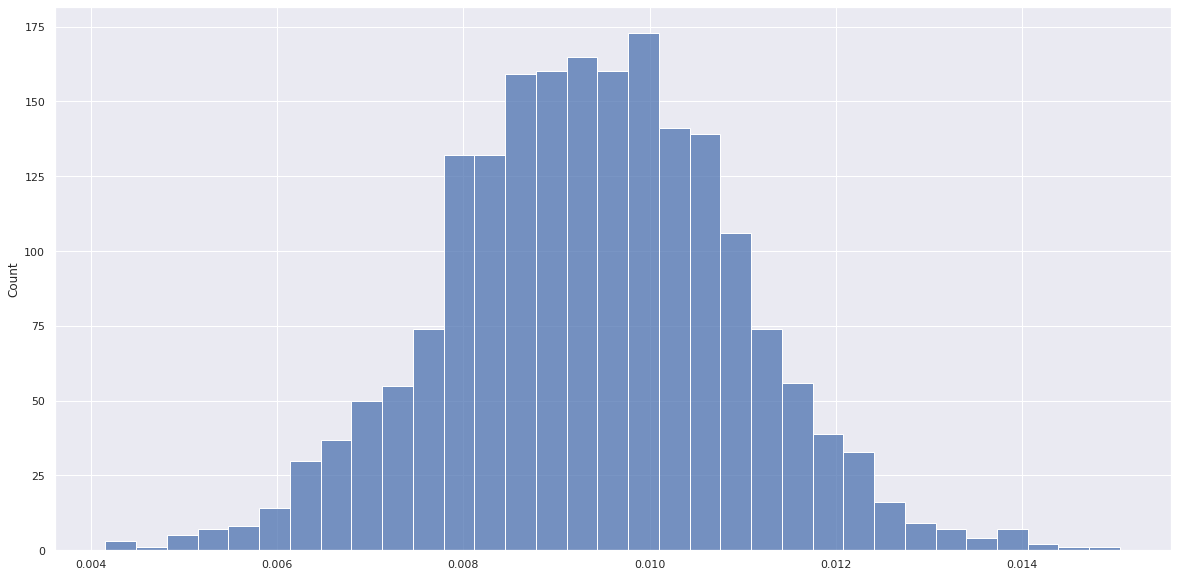

In [15]:
diff_ctr = global_ctr_1 - global_ctr_2 #распределение разницы между глобальными ctr: контроль - тест
sns.set(rc={'figure.figsize':(20, 10)})
sns.histplot(diff_ctr)

**Тест Манна-Уитни**

In [16]:
p_value_man = stats.mannwhitneyu(df[df.exp_group==1].ctr, df[df.exp_group==2].ctr)[1]

In [17]:
p_value_man

4.632205841806026e-45

 **t-тест на сглаженном ctr (α=5)**

In [18]:
alpha = 5
global_ctr_1 = df[df.exp_group==1].likes.sum()/df[df.exp_group==1].views.sum()
global_ctr_2 = df[df.exp_group==2].likes.sum()/df[df.exp_group==2].views.sum()

In [19]:
group_1 = (df[df.exp_group==1].likes + alpha * global_ctr_1)/(df[df.exp_group==1].views + alpha)
group_2 = (df[df.exp_group==2].likes + alpha * global_ctr_2)/(df[df.exp_group==2].views + alpha)

In [20]:
gr_1 = pd.DataFrame({'usual': df[df.exp_group==1].ctr.to_list(), 'smooth':group_1.to_list()})
gr_2 = pd.DataFrame({'usual': df[df.exp_group==2].ctr.to_list(), 'smooth':group_2.to_list()})

Распределение сглаженных CTR в контрольной и тестовой группах:

<Axes: ylabel='Count'>

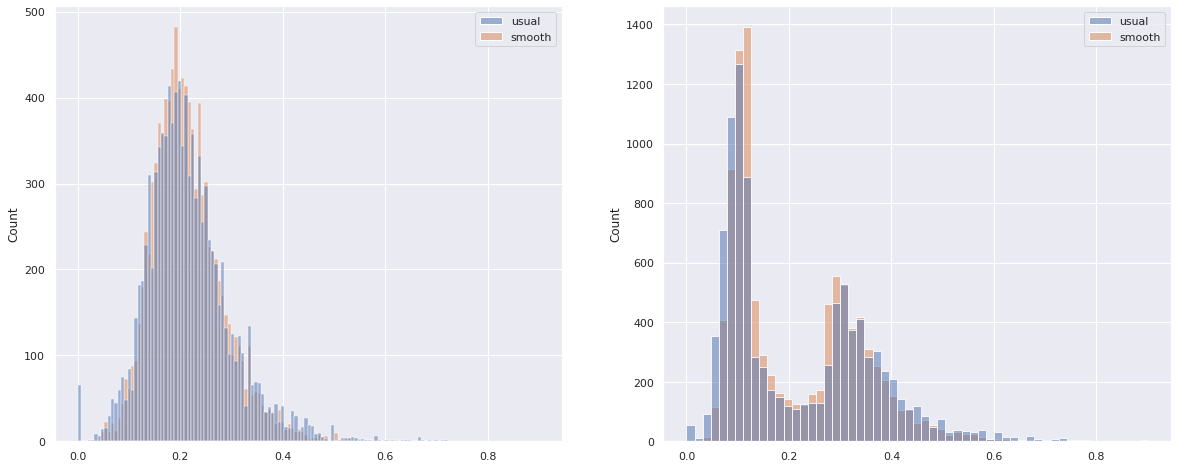

In [21]:
ctrs, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
sns.histplot(ax=axes[0], data=gr_1, alpha=0.5, kde=False) 
sns.histplot(ax=axes[1], data=gr_2, alpha=0.5, kde=False) 

In [22]:
smoothed_p_value = stats.ttest_ind(group_1, group_2, equal_var=False)[1]

In [23]:
smoothed_p_value

0.05166679015318526

**t-тест и тест Манна-Уитни поверх бакетного преобразования**

In [24]:
q_buc = """
    select exp_group,
           bucket,
           sum(likes)/sum(views) as bucket_ctr
    from (
        select exp_group,
               xxHash64(user_id)%50 as bucket,
               user_id,
               sum(action = 'like') as likes,
               sum(action = 'view') as views,
               sum(action = 'like')/sum(action = 'view') as ctr
        from {db}.feed_actions
        where date(time) between date('2024-03-29') and date('2024-04-04')
              and exp_group in (1, 2)
        group by user_id, exp_group, bucket)
    group by exp_group, bucket
"""
df = pandahouse.read_clickhouse(q_buc, connection=connection)

Распределение CTR в контрольной и тестовой группах после бакетного преобразования:

<Axes: ylabel='Count'>

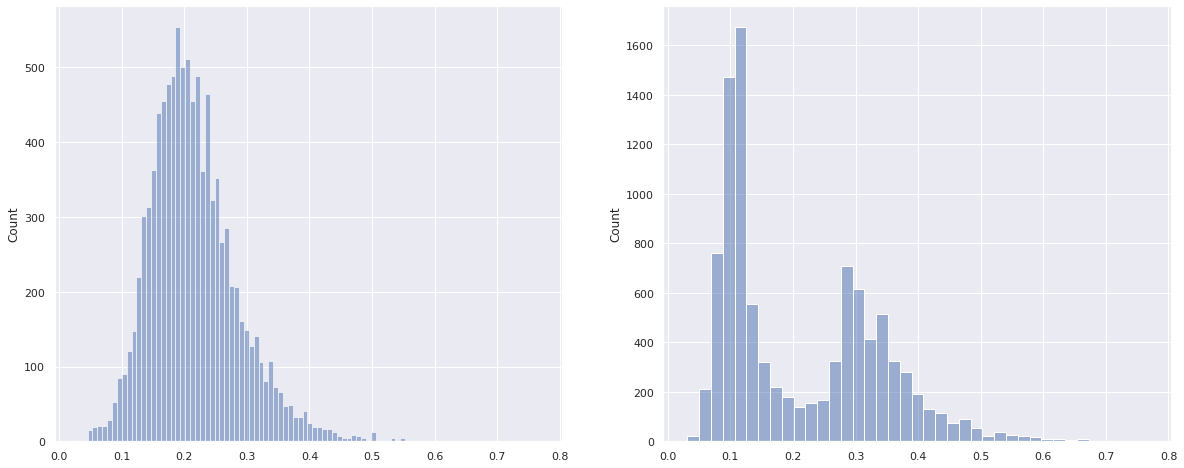

In [25]:
ctrs, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
sns.histplot(ax=axes[0], data=group_1, alpha=0.5, kde=False) 
sns.histplot(ax=axes[1], data=group_2, alpha=0.5, kde=False) 

In [26]:
buc_ttest_pvalue = stats.ttest_ind(df[df.exp_group==1].bucket_ctr, df[df.exp_group==2].bucket_ctr, equal_var=False)[1]
buc_man_pvalue = stats.mannwhitneyu(df[df.exp_group==1].bucket_ctr, df[df.exp_group==2].bucket_ctr)[1]

In [27]:
print(buc_ttest_pvalue)
print(buc_man_pvalue)

4.592644937473873e-07
2.6576427804010095e-07


#### Summary

In [28]:
results = pd.DataFrame({'ttest': [p_value_ttest], 'mann': [p_value_man], 'smoothed_ttest': [smoothed_p_value], 'buc_ttest': [buc_ttest_pvalue], 'buc_mann': [buc_man_pvalue]})

In [29]:
results

,ttest,mann,smoothed_ttest,buc_ttest,buc_mann
0,0.685373,4.632206e-45,0.051667,4.592645e-07,2.657643e-07


<Axes: ylabel='Count'>

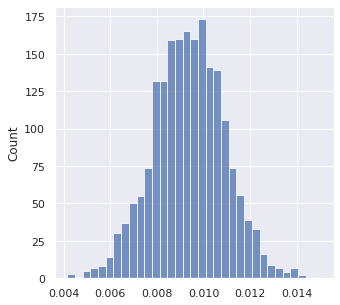

In [30]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.histplot(diff_ctr)

### Вывод:

1. Только t-test на обычных и на сглаженных данных (причём значение p-value на сглаженных данных было близко к 0.05 - отвержению нулевой гипотезы, что может говорить о том, что сглаживание действительно увеличивает точность теста), показал, что различие между тестовой и контрольной группами не является статистически значимым (поскольку p-value >= 0.05), другие же тесты показали противоположный результат - группы имеют значимые различия.

2. Анализ результатов тестов

    Краткий анализ графиков:
     - Распределение контрольной группы унимодальное, а тестовой группы - бимодальное.
     - Распределение группового CTR контрольной группы лежит правее группового CTR тестовой группы, не имеет пересечений.
     - Распределение сглаженных CTR в обеих группах не сильно отличаются от обычного CTR.
     - При бакетном преобразовании форма распределений не меняется.
       
    **1. t-test** мог не показать различий по данным причинам: 
      - Распределение CTR тестовой группы бимодальное, причём мода контрольной группы лежит между двумя модами распределения тестовой группы, то есть среднее по тестовой группе может наложиться на среднее контрольной группы за счёт бимодальности.
      - Распределение CTR тестовой группы имеет довольно длинный правый хвост.

     **2. t-test на сглаженных данных и после бакетного преобразования** повёл себя лучше, возможно, за счёт того, что сглаживание и усреднение по бакетам убрали выбросы (длинный правый хвост).

     **3. Пуассоновский бустреп** показал, что группы не пересекаются, причём групповой CTR контрольной группы лежит правее тестовой, что можно интерпретировать как "в тестовой группе CTR выше", однако, после бакетного преобразования, p-value возросло, вероятно, это связано с тем, что был убран вклад выбросов из распределения тестовой группы.
  
     **4. Тест Манна-Уитни** показал различия между группами, поскольку он является непараметрическим, и для него не важен характер распределения.
    
3. Раскатывать алгоритм не стоит, потому что: 
    - Исходя из графика, CTR 2-ой группы стал хуже, в данном случае доверять ttest'у не стоит, поскольку на него оказывает влияние форма распределения тестовой группы.
    - Большинство тестов (в том числе непараметрические) показали, что отличие между группами есть, причём благодаря пуассоновскому бутсрепу можно понять, что групповой CTR контрольной группы находится гораздо правее тестовой, это говорит о том, что в тестовой CTR не увеличился, а наоборот уменьшился.